--- 
## Operations visualization from different executions of TestBench

In [112]:
import glob
import os
import pandas as pd
import seaborn as snsß
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import seaborn as sns
import pandas as pd
from collections import deque
import shapely
import shapely.wkt
import time
import struct
import math
import numpy as np
from shapely import GeometryType as GT
import bisect
from bitarray import bitarray, util, bits2bytes
import random
import tqdm


In [120]:
FLOAT_SIZE = 32
COUNT_PER_PRECISION = 100000

In [121]:
def uint_to_ba(x, length):
        if x == 0:
            return util.zeros(length or 1, "big")

        a = bitarray(0, "big")

        a.frombytes(x.to_bytes(bits2bytes(x.bit_length()), byteorder="big"))
        la = len(a)
        if la == length:
            return a

        return a[-length:] if la > length else util.zeros(length - la, "big") + a


In [122]:


def float2bin(float):
    decimal_part, integral_part = math.modf(float)
    sign = 0 if float > 0 else 1
    decimal_part = decimal_part * (1 - sign * 2)
    integral_part = int(integral_part) * (1 - sign * 2)

    integral_bin = bitarray()
    while(integral_part >= 1):
        integral_bin.append(integral_part % 2)
        integral_part = integral_part >> 1
    integral_bin.reverse()

    decimal_bin = bitarray()
    beg_bits_zero, had_1s = 0, False
    while(decimal_part != 0):
        decimal_part *= 2
        rem = 0 if decimal_part < 1 else 1
        if not had_1s and len(integral_bin) == 0:
            if rem == 0:
                beg_bits_zero += 1
                continue
            else:
                had_1s = True
                
        decimal_bin.append(rem)
        if decimal_part >= 1:
            decimal_part -= 1
    
    if len(integral_bin) == 0:
        exponent = 127 - beg_bits_zero - 1
    else:
        exponent = 127 + len(integral_bin) - 1

    res = bitarray()
    res.append(sign)
    res.extend(uint_to_ba(exponent,8))
    integral_bin.extend(decimal_bin)
    while len(integral_bin) < FLOAT_SIZE - 9 + 1:
        integral_bin.append(0)

    res.extend(integral_bin[1:FLOAT_SIZE - 9 + 1])
    return res


def bin2float(precision_float):
    sign = (1 + (-2 * precision_float[0]))
    exponent = util.ba2int(precision_float[1:9], signed=False) - 127
    decimal_part = precision_float[9:]
    decimal = 1
    for i in range(1,FLOAT_SIZE - 9 + 1):
        decimal += decimal_part[i - 1] * math.pow(2, -i)
    return round(decimal * sign * math.pow(2,exponent),7)


def bits2Long(bits):
    res = 0
    for ele in bits:
        res = (res << 1) | ele
    return res

def long2bits(num):      
    binary = bin(num)[2:]
    res =  bitarray()
    res.extend('0' * (FLOAT_SIZE - len(binary)))
    res.extend(binary)
    return res


from math import floor, log10, inf
def num_zeros(decimal):
    return inf if decimal == 0 else -floor(log10(abs(decimal))) - 1

In [123]:
dec_errors = {}
for float_size in tqdm.tqdm(range(16,65)):
    FLOAT_SIZE = float_size
    dec_errors[FLOAT_SIZE] = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0} 
    for i in range(COUNT_PER_PRECISION):
        float = round(random.uniform(0.0, 180),7)
        if bin2float(float2bin(float)) != float:
            round_err = abs(bin2float(float2bin(float)) - float)
            dec_errors[FLOAT_SIZE][num_zeros(round_err)] += 1
bar_plot = pd.DataFrame(dec_errors).T

100%|██████████| 49/49 [02:53<00:00,  3.55s/it]


In [124]:
bar_plot2 = bar_plot/COUNT_PER_PRECISION

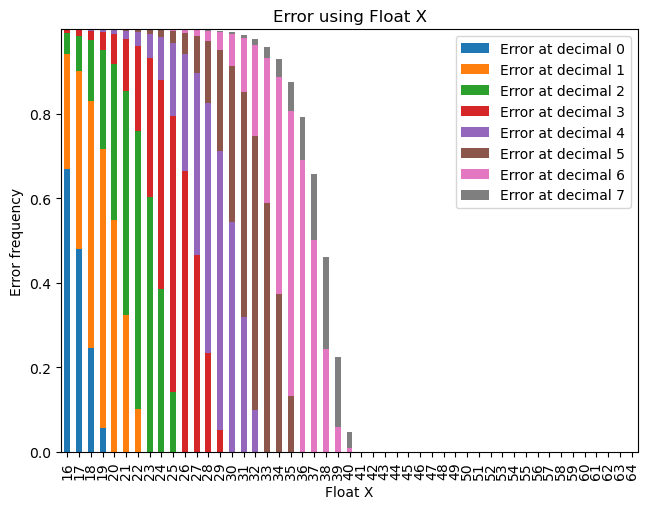

In [125]:
bar_plot2.plot (kind = 'bar', stacked = True)
plt.tight_layout()
plt.xlabel ('Float X')
plt.ylabel ('Error frequency')
plt.title ('Error using Float X')
plt.legend(labels=[ "Error at decimal 0", 
                    "Error at decimal 1", 
                    "Error at decimal 2", 
                    "Error at decimal 3", 
                    "Error at decimal 4", 
                    "Error at decimal 5",
                    "Error at decimal 6",
                    "Error at decimal 7"
                    ])

plt.show ()